## Imports and constants

In [1]:
%matplotlib inline

import os
import numpy as np
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.analysis.fitter import Fitter
from onix.helpers import data_identifier, console_bold, present_float

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [3]:
name = "Free Induction Decay"
analysis_number = None
identifier = None

In [4]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

## Setup

In [115]:
data_numbers = [2465]
data, headers = get_experiment_data(data_numbers[0])
identifier = "data " + data_identifier(data_numbers)

In [116]:
headers

{'params': {'aom_channel': 2,
  'digitizer_channel': 0,
  'repeats': 10000,
  'segment_length': 100,
  'excitation': {'frequency': 80 <Unit('megahertz')>,
   'amplitude': 2000,
   'time': 0.5 <Unit('millisecond')>},
  'coherence': {'frequency': 72 <Unit('megahertz')>,
   'amplitude': 1200,
   'time': 1 <Unit('millisecond')>},
  'yso': {'use': False,
   'eo_channel': 1,
   'frequency_excitation': 300 <Unit('megahertz')>,
   'frequency_coherence': -275 <Unit('megahertz')>,
   'eo_amplitude': 24000,
   'switch_ao_channel': 0,
   'switch_ao_frequency': 80 <Unit('megahertz')>,
   'switch_ao_amplitude_excitation': 1500,
   'switch_ao_amplitude_coherence': 1000}},
 'data_info': {'name': 'Free Induction Decay',
  'data_number': 2465,
  'save_time': '2023-11-03 16:50:32',
  'save_epoch_time': 1699044632.738441}}

## Overall plot

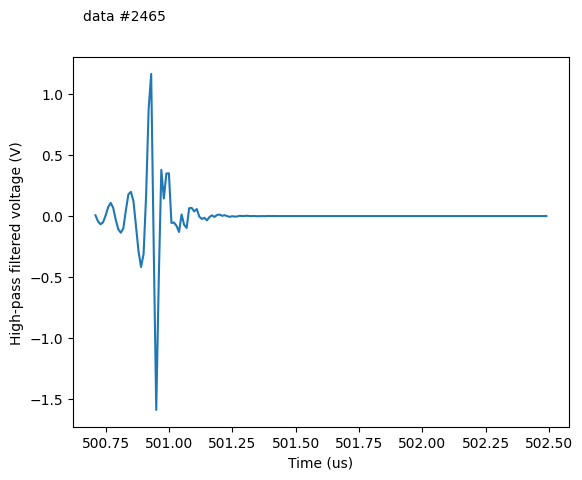

In [117]:
time_mask = np.bitwise_and(data["times"]>500.7e-06, data["times"]<502.5e-06)
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data["times"][time_mask] * 1e6, butter_highpass_filter(np.average(data["voltages"], axis=0)[time_mask], 1e7, 1e8))
# ax.errorbar(data["times"] * 1e3, butter_highpass_filter(np.average(data["voltages"], axis=0), 1e7, 1e8))
# ax.errorbar(data["times"][time_mask] * 1e6, np.average(data["voltages"], axis=0)[time_mask])
# ax.errorbar(data["times"] * 1e6, np.average(data["voltages"], axis=0))


ax.set_xlabel("Time (us)")
ax.set_ylabel("High-pass filtered voltage (V)")
#ax.set_ylim(1.325, 1.375)
# ax.set_ylim(0.35, 0.45)
# ax.set_ylim(-0.1, 0.1)
# ax.set_xlim(0.500, 0.502)
# ax.set_ylim(-5.4, -3.5)
#ax.legend()
#plt.tight_layout()
#ax.set_xlim(20e-3, 21e-3)
plt.show()

In [118]:
# np.savetxt("optical_fid_phase_pi.csv", np.transpose([data["times"][time_mask] * 1e3, butter_highpass_filter(np.average(data["voltages"], axis=0)[time_mask], 1e7, 1e8)]), delimiter=",")

In [119]:
# butter_highpass_filter(np.average(data["voltages"], axis=0), 10, 1e8)

## Plotting difference

In [122]:
background_num = [2465]
data_num = [2464]
background, background_headers = get_experiment_data(background_num[0])
data, data_headers = get_experiment_data(data_num[0])

(100, 149984)


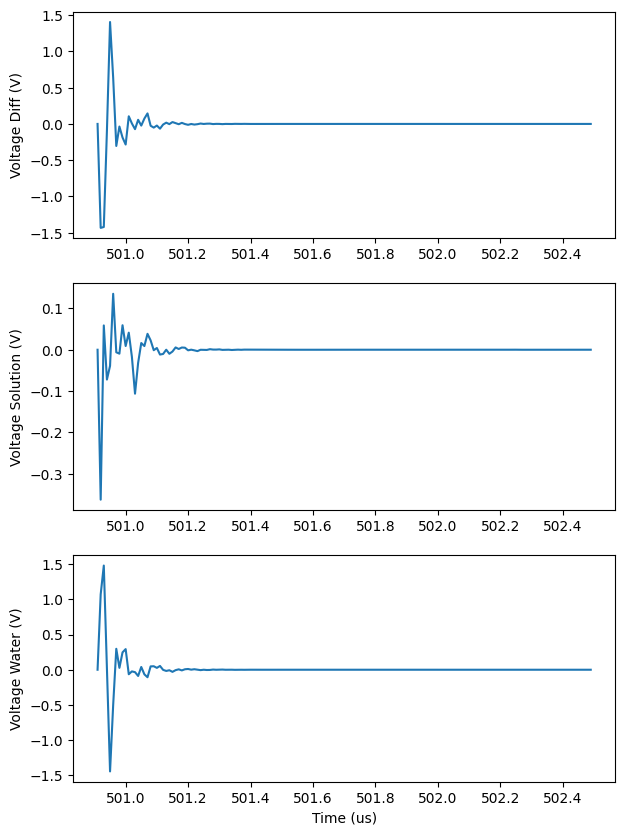

In [123]:
time_mask = np.bitwise_and(data["times"]>500.9e-06, data["times"]<502.5e-06)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7,10))
print(np.shape(data["voltages"]))
# add_label(ax2)

voltage_diff = butter_highpass_filter(np.average(data["voltages"], axis=0)[time_mask], 1e7, 1e8)-butter_highpass_filter(np.average(background["voltages"], axis=0)[time_mask], 1e7, 1e8)
ax1.errorbar(data["times"][time_mask] * 1e6 , voltage_diff)
ax2.errorbar(data["times"][time_mask] * 1e6 , butter_highpass_filter(np.average(data["voltages"], axis=0)[time_mask], 1e7, 1e8))
ax3.errorbar(background["times"][time_mask] * 1e6 , butter_highpass_filter(np.average(background["voltages"], axis=0)[time_mask], 1e7, 1e8))

ax3.set_xlabel("Time (us)")
ax1.set_ylabel("Voltage Diff (V)")
ax3.set_ylabel("Voltage Water (V)")
ax2.set_ylabel("Voltage Solution (V)")

#ax.legend()
#plt.tight_layout()
#ax.set_xlim(20e-3, 21e-3)
plt.show()

## Fourier

In [113]:
background_num = [2463]
data_num = [2464]
background, background_headers = get_experiment_data(background_num[0])
data, data_headers = get_experiment_data(data_num[0])

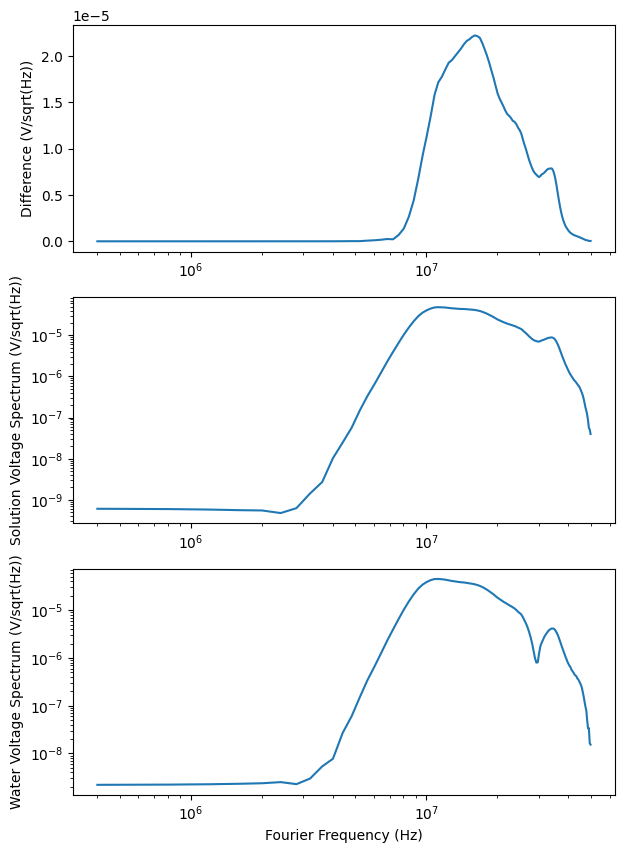

In [114]:
def get_voltagespectrum(V, t):
    V = V - np.average(V)
    
    T = t[-1] - t[0]
    dt = t[1] - t[0]
    
    V_T = V/np.sqrt(T)
    V_f = np.fft.fft(V_T)*dt
    S_V = np.abs(V_f)**2
    f = np.fft.fftfreq(len(V_T),dt)
    
    W_V = 2*S_V[f>0]
    f = f[f>0]
    df = f[1]-f[0]
    return f, W_V

time_mask = np.bitwise_and(data["times"]>500.0e-06, data["times"]<502.5e-06)

f_1, W_V_1 = get_voltagespectrum(butter_highpass_filter(np.average(data["voltages"], axis=0)[time_mask], 1e7, 1e8), data["times"][time_mask])
f_2, W_V_2 = get_voltagespectrum(butter_highpass_filter(np.average(background["voltages"], axis=0)[time_mask], 1e7, 1e8), background["times"][time_mask])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7,10))

power_diff = W_V_1-W_V_2
ax1.semilogx(f_1, np.sqrt(np.abs(power_diff)))
# ax2.semilogx(f_1, np.sqrt(W_V_1))
# ax3.semilogx(f_2, np.sqrt(W_V_2))
ax2.loglog(f_1, np.sqrt(W_V_1))
ax3.loglog(f_2, np.sqrt(W_V_2))

ax3.set_xlabel("Fourier Frequency (Hz)")
ax1.set_ylabel("Difference (V/sqrt(Hz))")
ax2.set_ylabel("Solution Voltage Spectrum (V/sqrt(Hz))")
ax3.set_ylabel("Water Voltage Spectrum (V/sqrt(Hz))")

#ax.legend()
#plt.tight_layout()
#ax.set_xlim(20e-3, 21e-3)
plt.show()

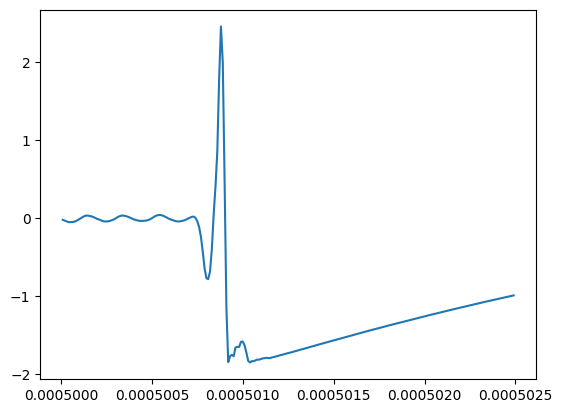

In [81]:
plt.plot(data["times"][time_mask], np.average(data["voltages"],axis=0)[time_mask])